## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Sun May 22 17:00:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:08:00.0 Off |                  N/A |
| 23%   32C    P2    83W / 250W |   2909MiB / 11178MiB |     49%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 25
    dummy = 1
    for epoch in range(120):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.sqrt(total_loss / len(train_dataset))
        val_loss = np.sqrt(val_loss / len(val_dataset))

        if dummy == 1:
            dummy -= 1
        else: 
            last_valid = val_losses[-1]
            if last_valid < val_loss:
                early_stop_counter += 1
            else:
                pickle.dump(pred, open('models/mlp_7_layer_' + city + '_large', 'wb'))

            if early_stop_counter == early_stop_criteria:
                break
            
        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 8974.69573142332 val_loss: 5272.925414060444
epoch 1 train_loss: 5200.71174066818 val_loss: 5270.45053638221
epoch 2 train_loss: 2813.8695364374876 val_loss: 532.8455079967425
epoch 3 train_loss: 463.72990299314375 val_loss: 434.6054733833379
epoch 4 train_loss: 408.37332902487947 val_loss: 399.7315985644463
epoch 5 train_loss: 387.4113552573013 val_loss: 396.2844125917896
epoch 6 train_loss: 384.06036588046675 val_loss: 400.15842858499656
epoch 7 train_loss: 381.6000869025798 val_loss: 406.20818540053085
epoch 8 train_loss: 378.63186757329987 val_loss: 407.946752516481
epoch 9 train_loss: 375.52912930250784 val_loss: 395.3483458602627
epoch 10 train_loss: 371.7871205417745 val_loss: 383.82331716857954
epoch 11 train_loss: 368.8009630583084 val_loss: 378.1349795405576
epoch 12 train_loss: 365.2700828858545 val_loss: 370.1911176084895
epoch 13 train_loss: 362.37185493434566 val_loss: 360.76834709165274
epoch 14 train_loss: 359.1875346901419 val_loss: 353

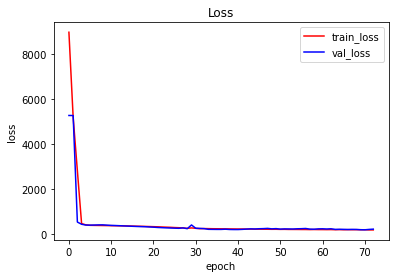

city: miami
epoch 0 train_loss: 19731.49490185755 val_loss: 12177.5726017675
epoch 1 train_loss: 9220.784001985956 val_loss: 1064.6652606515618
epoch 2 train_loss: 931.0953532893946 val_loss: 795.1686180859456
epoch 3 train_loss: 733.6536477250563 val_loss: 430.5206640159531
epoch 4 train_loss: 462.14703555551824 val_loss: 419.97022565059814
epoch 5 train_loss: 529.1555311100526 val_loss: 326.8826288971701
epoch 6 train_loss: 422.5191879550841 val_loss: 415.49134209374296
epoch 7 train_loss: 437.60063350953965 val_loss: 322.1821239802851
epoch 8 train_loss: 459.54741468283385 val_loss: 311.91658588618395
epoch 9 train_loss: 416.8488377486447 val_loss: 330.85249741106054
epoch 10 train_loss: 482.5556408385517 val_loss: 324.2919426750867
epoch 11 train_loss: 384.0336924779054 val_loss: 317.95541827551847
epoch 12 train_loss: 430.1784536310831 val_loss: 313.3811307969624
epoch 13 train_loss: 419.49140825801925 val_loss: 329.3098997711827
epoch 14 train_loss: 414.0148576029965 val_loss: 35

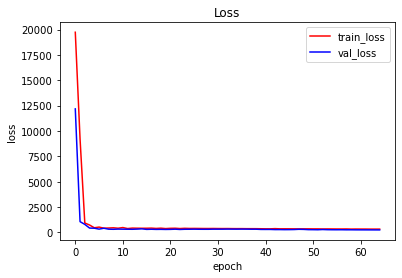

city: pittsburgh
epoch 0 train_loss: 15496.703741779576 val_loss: 6840.640725382835
epoch 1 train_loss: 6762.366431168462 val_loss: 6840.1138599044625
epoch 2 train_loss: 6762.969910980001 val_loss: 6839.993734042046
epoch 3 train_loss: 6763.449799344659 val_loss: 6839.986839842486
epoch 4 train_loss: 6763.870244999567 val_loss: 6840.0093023050795
epoch 5 train_loss: 6764.236947754225 val_loss: 6840.254508451737
epoch 6 train_loss: 6764.511398024906 val_loss: 6841.60655297348
epoch 7 train_loss: 6764.7913070014865 val_loss: 6841.149601791423
epoch 8 train_loss: 6765.056005562657 val_loss: 6840.5144735900885
epoch 9 train_loss: 6765.34249761069 val_loss: 6840.433730510593
epoch 10 train_loss: 6765.395034167014 val_loss: 6843.424663445855
epoch 11 train_loss: 6765.56989755716 val_loss: 6846.142780181741
epoch 12 train_loss: 6765.8533581122665 val_loss: 6848.735707638242
epoch 13 train_loss: 6765.8021415245585 val_loss: 6843.328066340378
epoch 14 train_loss: 6765.865536797861 val_loss: 68

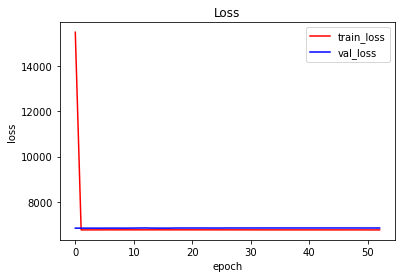

city: dearborn
epoch 0 train_loss: 42779.74993844657 val_loss: 9818.398126998509
epoch 1 train_loss: 7891.119284389407 val_loss: 2385.1253849260047
epoch 2 train_loss: 1865.584734603892 val_loss: 1102.937722113288
epoch 3 train_loss: 1053.6606631695572 val_loss: 626.1432424404568
epoch 4 train_loss: 723.7315415950071 val_loss: 501.89680868721274
epoch 5 train_loss: 608.8031469460786 val_loss: 477.0927614029718
epoch 6 train_loss: 721.4502433668582 val_loss: 451.18303717104175
epoch 7 train_loss: 551.3829898815208 val_loss: 491.6135769267707
epoch 8 train_loss: 567.8536362120112 val_loss: 445.0486045591752
epoch 9 train_loss: 596.881954359447 val_loss: 446.6706862309762
epoch 10 train_loss: 594.9348352839864 val_loss: 442.8160150464376
epoch 11 train_loss: 592.2688136279638 val_loss: 448.1393997000705
epoch 12 train_loss: 587.631533445386 val_loss: 443.4953771650215
epoch 13 train_loss: 586.1632592492318 val_loss: 439.9106739847757
epoch 14 train_loss: 582.1108984658315 val_loss: 435.19

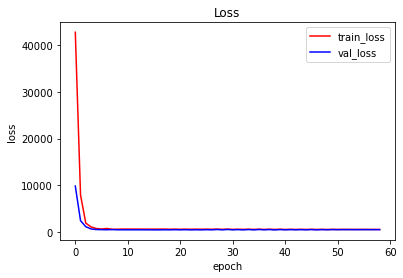

city: washington-dc
epoch 0 train_loss: 21555.820680411893 val_loss: 5452.497871402221
epoch 1 train_loss: 5425.804708291107 val_loss: 5431.353151180254
epoch 2 train_loss: 5423.821536251919 val_loss: 5431.092008231221
epoch 3 train_loss: 5423.801977706301 val_loss: 5430.887242800096
epoch 4 train_loss: 5423.929116739138 val_loss: 5430.758258333507
epoch 5 train_loss: 5424.117251275588 val_loss: 5430.691611399242
epoch 6 train_loss: 5424.31564428603 val_loss: 5430.794936220912
epoch 7 train_loss: 5424.5476637355905 val_loss: 5431.022131581704
epoch 8 train_loss: 5424.796724506653 val_loss: 5431.423141226837
epoch 9 train_loss: 5424.985323955635 val_loss: 5432.094552884467
epoch 10 train_loss: 5425.055459711455 val_loss: 5432.6363887230145
epoch 11 train_loss: 5425.124363047027 val_loss: 5433.195024593533
epoch 12 train_loss: 5425.255447064204 val_loss: 5434.185745879962
epoch 13 train_loss: 5425.428934889902 val_loss: 5435.563937992214
epoch 14 train_loss: 5425.653485818617 val_loss: 5

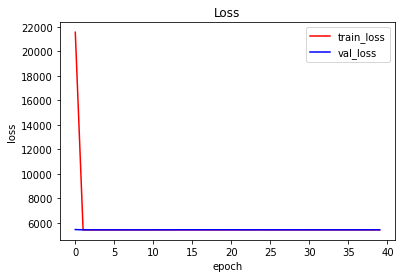

city: palo-alto
epoch 0 train_loss: 15091.021919402896 val_loss: 8867.6100215198
epoch 1 train_loss: 8433.123370921128 val_loss: 8151.676772888435
epoch 2 train_loss: 7982.179803736809 val_loss: 7779.71021668277
epoch 3 train_loss: 7926.240453283872 val_loss: 7774.087937186801
epoch 4 train_loss: 7920.149289690927 val_loss: 7765.273437383786
epoch 5 train_loss: 6661.349845731035 val_loss: 4141.007858168785
epoch 6 train_loss: 3607.378886559737 val_loss: 3167.7349763028074
epoch 7 train_loss: 3107.913980576366 val_loss: 2847.675424707222
epoch 8 train_loss: 2571.949071376675 val_loss: 1903.6222601447887
epoch 9 train_loss: 1705.6746439117169 val_loss: 1375.9152694247741
epoch 10 train_loss: 1216.8234062057327 val_loss: 1066.6762545830534
epoch 11 train_loss: 995.9649493127421 val_loss: 907.9380049232233
epoch 12 train_loss: 935.3239877277313 val_loss: 872.9235260079786
epoch 13 train_loss: 821.0861564679686 val_loss: 838.6259866763916
epoch 14 train_loss: 758.9271417430955 val_loss: 900

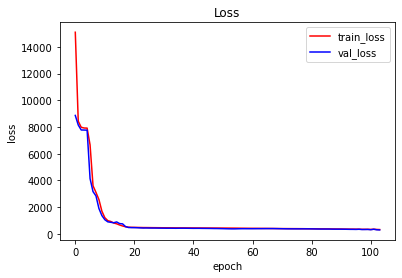

CPU times: user 11min 25s, sys: 15.7 s, total: 11min 40s
Wall time: 11min 41s


In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=1e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
#     pickle.dump(pred, open('models/ta_model_baseline_' + city + '_large', 'wb'))

In [8]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('models/mlp_7_layer_' + city + '_large', 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [9]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-33.071861,-562.493958,-32.381569,-561.741089,-32.902180,-562.486877,-32.842567,-562.572571,-33.774849,...,-31.643402,-563.464600,-32.225563,-563.658325,-31.348967,-563.918274,-32.578751,-562.704468,-31.785648,-563.642517
1,1_austin,-348.180817,-10.061088,-347.373260,-9.583283,-349.200928,-9.419303,-346.826050,-8.566005,-348.156891,...,-348.211975,-10.618839,-348.369049,-10.648561,-348.049377,-10.371942,-348.303680,-9.269769,-348.184265,-9.304135
2,2_austin,52.458046,-249.916229,52.525311,-249.739578,52.807865,-249.788727,52.583717,-249.760361,52.578190,...,52.897919,-249.947281,52.509701,-249.693420,52.627625,-249.332184,52.660305,-249.738159,52.536945,-249.577606
3,3_austin,-106.412537,1801.758301,-106.637230,1802.245605,-107.405861,1802.330322,-107.008705,1801.695312,-105.884926,...,-102.596268,1804.826782,-101.932991,1804.780273,-101.541008,1803.616333,-101.666283,1803.831909,-100.996994,1806.793213
4,4_austin,1236.020996,-658.738098,1235.410767,-658.417786,1235.456055,-658.696838,1235.276001,-659.138489,1235.582275,...,1228.324219,-654.807495,1228.653687,-654.485046,1228.614014,-655.299133,1228.171265,-654.838013,1228.640381,-654.541931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1379.160156,-488.224854,-1377.991455,-485.069275,-1381.872437,-488.711243,-1380.208740,-487.881195,-1381.742065,...,-1377.887085,-497.289246,-1381.043701,-497.131775,-1379.538452,-496.734375,-1377.403076,-494.593414,-1378.279297,-499.486237
29839,1682_palo-alto,133.269287,-23.854750,133.765503,-23.807421,133.593063,-23.910589,133.558258,-24.244616,133.248184,...,133.682968,-24.020914,133.318680,-24.322424,133.943115,-24.290056,133.740662,-24.611841,133.533646,-24.533318
29840,1683_palo-alto,-1459.428223,2158.641846,-1458.060059,2158.974365,-1461.255737,2158.271240,-1459.459351,2156.268066,-1458.233276,...,-1457.260132,2153.830566,-1454.856201,2153.583740,-1457.374268,2153.721436,-1457.027100,2154.790283,-1456.548828,2153.780273
29841,1684_palo-alto,1048.646484,1386.937256,1052.282227,1388.299194,1049.287354,1386.492920,1048.919556,1387.659546,1049.391235,...,1052.771118,1385.859619,1050.383545,1388.163086,1049.038452,1384.712646,1049.052246,1383.617188,1050.351318,1382.453735


In [10]:
all_predictions.to_csv('out.csv', index=False)

In [11]:
pd.read_csv('out.csv')

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-33.071860,-562.493960,-32.381570,-561.741100,-32.902180,-562.486900,-32.842567,-562.572600,-33.774850,...,-31.643402,-563.464600,-32.225563,-563.658300,-31.348967,-563.918300,-32.578750,-562.704470,-31.785648,-563.642500
1,1_austin,-348.180820,-10.061088,-347.373260,-9.583283,-349.200930,-9.419303,-346.826050,-8.566005,-348.156900,...,-348.211980,-10.618839,-348.369050,-10.648561,-348.049380,-10.371942,-348.303680,-9.269769,-348.184270,-9.304135
2,2_austin,52.458046,-249.916230,52.525310,-249.739580,52.807865,-249.788730,52.583717,-249.760360,52.578190,...,52.897920,-249.947280,52.509700,-249.693420,52.627625,-249.332180,52.660305,-249.738160,52.536945,-249.577600
3,3_austin,-106.412540,1801.758300,-106.637230,1802.245600,-107.405860,1802.330300,-107.008705,1801.695300,-105.884926,...,-102.596270,1804.826800,-101.932990,1804.780300,-101.541010,1803.616300,-101.666280,1803.831900,-100.996994,1806.793200
4,4_austin,1236.021000,-658.738100,1235.410800,-658.417800,1235.456000,-658.696840,1235.276000,-659.138500,1235.582300,...,1228.324200,-654.807500,1228.653700,-654.485050,1228.614000,-655.299130,1228.171300,-654.838000,1228.640400,-654.541930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1379.160200,-488.224850,-1377.991500,-485.069270,-1381.872400,-488.711240,-1380.208700,-487.881200,-1381.742100,...,-1377.887100,-497.289250,-1381.043700,-497.131770,-1379.538500,-496.734380,-1377.403100,-494.593400,-1378.279300,-499.486240
29839,1682_palo-alto,133.269290,-23.854750,133.765500,-23.807420,133.593060,-23.910590,133.558260,-24.244616,133.248180,...,133.682970,-24.020914,133.318680,-24.322424,133.943120,-24.290056,133.740660,-24.611841,133.533650,-24.533318
29840,1683_palo-alto,-1459.428200,2158.641800,-1458.060000,2158.974400,-1461.255700,2158.271200,-1459.459400,2156.268000,-1458.233300,...,-1457.260100,2153.830600,-1454.856200,2153.583700,-1457.374300,2153.721400,-1457.027100,2154.790300,-1456.548800,2153.780300
29841,1684_palo-alto,1048.646500,1386.937300,1052.282200,1388.299200,1049.287400,1386.492900,1048.919600,1387.659500,1049.391200,...,1052.771100,1385.859600,1050.383500,1388.163100,1049.038500,1384.712600,1049.052200,1383.617200,1050.351300,1382.453700
